Dataset shape: (10, 13)

Column names: ['Altitude', 'Vin', 'Mach', 'Nose Radius', 'Degree', 'Effective Cone Angle', 'Transition Start Location', 'Edge Mach Number', 'Local Re', 'Local Re upl', 'Loc TE', 'Mach No at Location', 'Re at TE']

Missing values per column:
Altitude                     0
Vin                          0
Mach                         0
Nose Radius                  0
Degree                       0
Effective Cone Angle         0
Transition Start Location    1
Edge Mach Number             1
Local Re                     2
Local Re upl                 1
Loc TE                       3
Mach No at Location          4
Re at TE                     4
dtype: int64

Available data points after cleaning: 8
Features shape: (8, 6)
Target range: 8.10e-01 to 6.56e+01

Training samples: 6
Testing samples: 2

Model Performance:
R² score: 0.957
Mean Absolute Error: 5.16e+00
MAE as % of mean: 14.6%

Feature Importance:
                feature  importance
0              Altitude    0.207

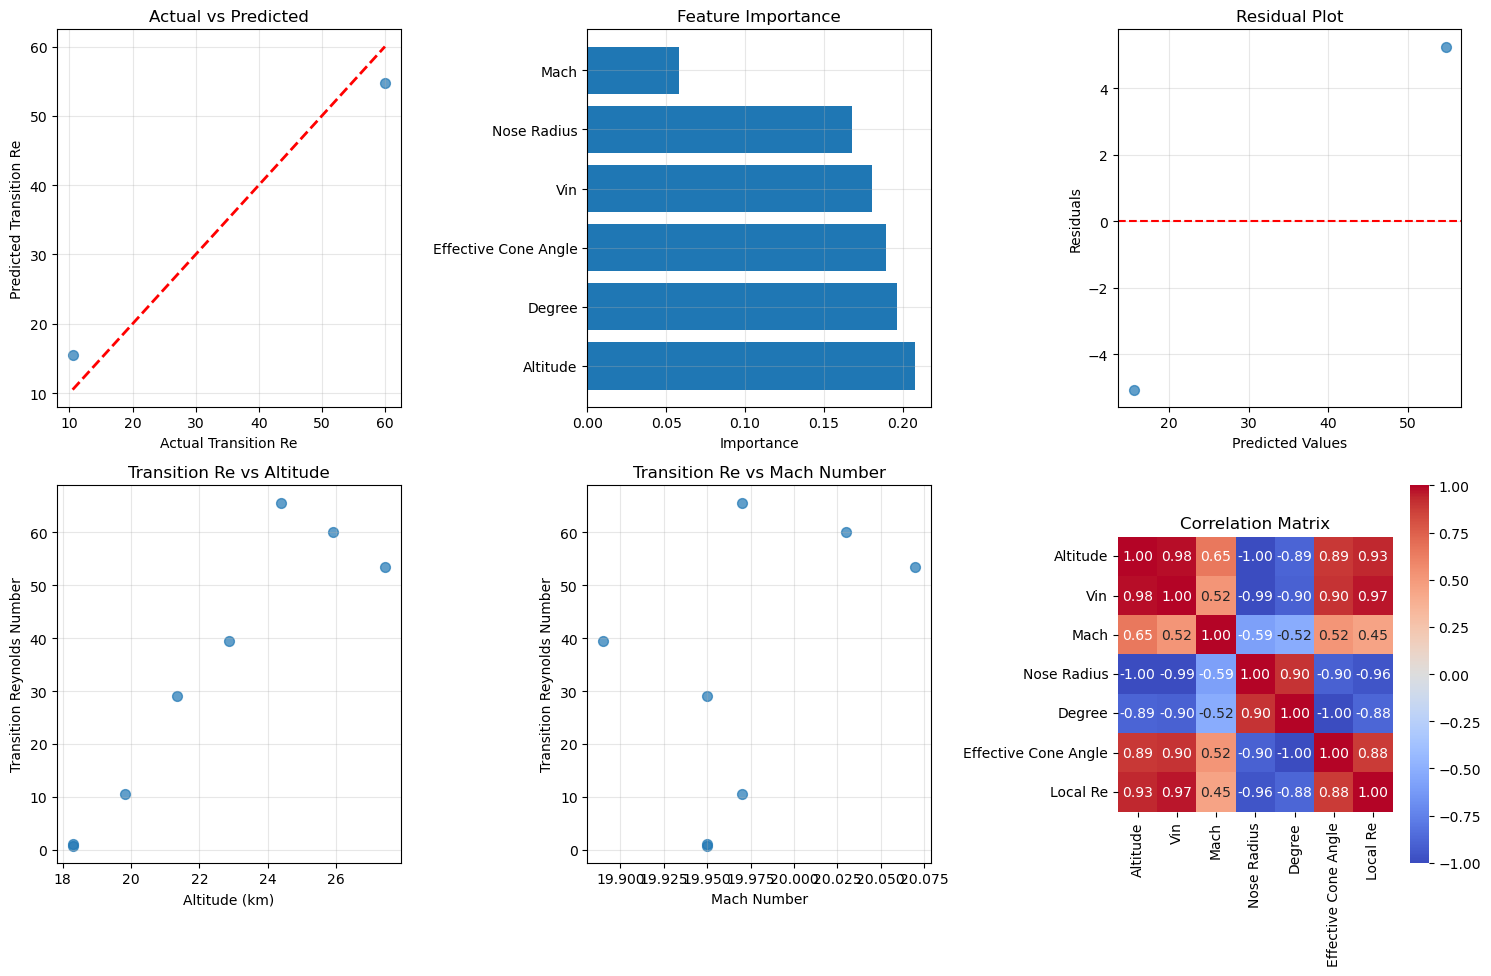


Additional Analysis:
Correlation with Transition Re:
  Vin: 0.966
  Altitude: 0.932
  Effective Cone Angle: 0.876
  Mach: 0.448
  Degree: -0.876
  Nose Radius: -0.957

Physical Trends:
Mach number effect on Transition Re:
  (19.89, 19.935]: 3.95e+01
  (19.935, 19.98]: 2.14e+01
  (19.98, 20.025]: nan
  (20.025, 20.07]: 5.68e+01

Altitude effect on Transition Re:
  (18.281, 20.575]: 4.17e+00
  (20.575, 22.86]: 3.42e+01
  (22.86, 25.145]: 6.56e+01
  (25.145, 27.43]: 5.68e+01

Cleaned dataset saved as 'cleaned_transition_data.csv'

Sample Predictions for Interpretation:

Sample 3:
  Actual Transition Re: 6.00e+01
  Predicted Transition Re: 5.47e+01
  Error: 8.8%
  Feature values:
    Altitude: 25.910
    Vin: 5.990
    Mach: 20.030
    Nose Radius: 3.327
    Degree: 0.000
    Effective Cone Angle: 5.000

Sample 7:
  Actual Transition Re: 1.05e+01
  Predicted Transition Re: 1.56e+01
  Error: 48.2%
  Feature values:
    Altitude: 19.810
    Vin: 5.860
    Mach: 19.970
    Nose Radius: 3.835

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
df = pd.read_csv('data_renamed.csv')

print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())

# Clean the data - handle missing values and problematic entries
df_clean = df.replace(['a', '', ' '], np.nan)
df_clean = df_clean.apply(pd.to_numeric, errors='coerce')

print(f"\nMissing values per column:")
print(df_clean.isnull().sum())

# Use available features for transition prediction
features = ['Altitude', 'Vin', 'Mach', 'Nose Radius', 'Degree', 'Effective Cone Angle']
target = 'Local Re'  # Transition Reynolds number

# Prepare data for ML - drop rows where any feature or target is missing
valid_mask = df_clean[features + [target]].notna().all(axis=1)
X = df_clean.loc[valid_mask, features]
y = df_clean.loc[valid_mask, target]

print(f"\nAvailable data points after cleaning: {len(X)}")
print(f"Features shape: {X.shape}")
print(f"Target range: {y.min():.2e} to {y.max():.2e}")

if len(X) > 5:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    
    print(f"\nTraining samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    
    # Train a model to predict transition Re
    model = RandomForestRegressor(
        n_estimators=200, 
        random_state=42,
        max_depth=5,
        min_samples_split=2,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mae_percent = (mae / y_test.mean()) * 100
    
    print(f"\nModel Performance:")
    print(f"R² score: {r2:.3f}")
    print(f"Mean Absolute Error: {mae:.2e}")
    print(f"MAE as % of mean: {mae_percent:.1f}%")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nFeature Importance:")
    print(feature_importance)
    
    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Actual vs Predicted
    axes[0, 0].scatter(y_test, y_pred, alpha=0.7, s=50)
    max_val = max(y_test.max(), y_pred.max())
    min_val = min(y_test.min(), y_pred.min())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Transition Re')
    axes[0, 0].set_ylabel('Predicted Transition Re')
    axes[0, 0].set_title('Actual vs Predicted')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Feature importance
    axes[0, 1].barh(feature_importance['feature'], feature_importance['importance'])
    axes[0, 1].set_xlabel('Importance')
    axes[0, 1].set_title('Feature Importance')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Residual plot
    residuals = y_test - y_pred
    axes[0, 2].scatter(y_pred, residuals, alpha=0.7, s=50)
    axes[0, 2].axhline(y=0, color='r', linestyle='--')
    axes[0, 2].set_xlabel('Predicted Values')
    axes[0, 2].set_ylabel('Residuals')
    axes[0, 2].set_title('Residual Plot')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Transition Re vs Altitude
    axes[1, 0].scatter(df_clean['Altitude'], df_clean['Local Re'], alpha=0.7, s=50)
    axes[1, 0].set_xlabel('Altitude (km)')
    axes[1, 0].set_ylabel('Transition Reynolds Number')
    axes[1, 0].set_title('Transition Re vs Altitude')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Transition Re vs Mach
    axes[1, 1].scatter(df_clean['Mach'], df_clean['Local Re'], alpha=0.7, s=50)
    axes[1, 1].set_xlabel('Mach Number')
    axes[1, 1].set_ylabel('Transition Reynolds Number')
    axes[1, 1].set_title('Transition Re vs Mach Number')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Correlation heatmap
    correlation_data = df_clean[features + [target]].dropna()
    if len(correlation_data) > 2:
        corr_matrix = correlation_data.corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                   ax=axes[1, 2], fmt='.2f', square=True)
        axes[1, 2].set_title('Correlation Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis
    print(f"\nAdditional Analysis:")
    
    # Check correlation with target
    corr_with_target = df_clean[features + [target]].corr()[target].sort_values(ascending=False)
    print("Correlation with Transition Re:")
    for feature, corr in corr_with_target.items():
        if feature != target:
            print(f"  {feature}: {corr:.3f}")
    
    # Analyze physical trends
    print(f"\nPhysical Trends:")
    
    # Mach number effect - FIXED with observed=False
    if 'Mach' in df_clean.columns:
        mach_data = df_clean[['Mach', 'Local Re']].dropna()
        if len(mach_data) > 0:
            mach_bins = pd.cut(mach_data['Mach'], bins=4)
            mach_effect = mach_data.groupby(mach_bins, observed=False)['Local Re'].mean()
            print("Mach number effect on Transition Re:")
            for bin_val, mean_re in mach_effect.items():
                print(f"  {bin_val}: {mean_re:.2e}")
    
    # Altitude effect - FIXED with observed=False
    if 'Altitude' in df_clean.columns:
        alt_data = df_clean[['Altitude', 'Local Re']].dropna()
        if len(alt_data) > 0:
            alt_bins = pd.cut(alt_data['Altitude'], bins=4)
            alt_effect = alt_data.groupby(alt_bins, observed=False)['Local Re'].mean()
            print("\nAltitude effect on Transition Re:")
            for bin_val, mean_re in alt_effect.items():
                print(f"  {bin_val}: {mean_re:.2e}")
    
else:
    print("Not enough data for machine learning. Showing basic analysis:")
    
    # Basic statistics
    print(f"\nBasic Statistics for Transition Re:")
    print(f"Mean: {y.mean():.2e}")
    print(f"Std: {y.std():.2e}")
    print(f"Min: {y.min():.2e}")
    print(f"Max: {y.max():.2e}")
    
    # Plot relationships
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Transition Re vs features
    for i, feature in enumerate(features[:4]):
        ax = axes[i//2, i%2]
        valid_data = df_clean[[feature, target]].dropna()
        if len(valid_data) > 0:
            ax.scatter(valid_data[feature], valid_data[target], alpha=0.7)
            ax.set_xlabel(feature)
            ax.set_ylabel('Transition Re')
            ax.set_title(f'Transition Re vs {feature}')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Save the cleaned dataset for future use
df_clean.to_csv('cleaned_transition_data.csv', index=False)
print(f"\nCleaned dataset saved as 'cleaned_transition_data.csv'")

# Show sample predictions for interpretation
if len(X) > 5:
    print(f"\nSample Predictions for Interpretation:")
    sample_indices = X_test.index[:5]  # First 5 test samples
    for idx in sample_indices:
        actual = y.loc[idx]
        predicted = model.predict([X.loc[idx]])[0]
        error_percent = abs((actual - predicted) / actual) * 100
        
        print(f"\nSample {idx}:")
        print(f"  Actual Transition Re: {actual:.2e}")
        print(f"  Predicted Transition Re: {predicted:.2e}")
        print(f"  Error: {error_percent:.1f}%")
        
        # Show feature values for this sample
        print("  Feature values:")
        for feature in features:
            value = X.loc[idx, feature]
            print(f"    {feature}: {value:.3f}")

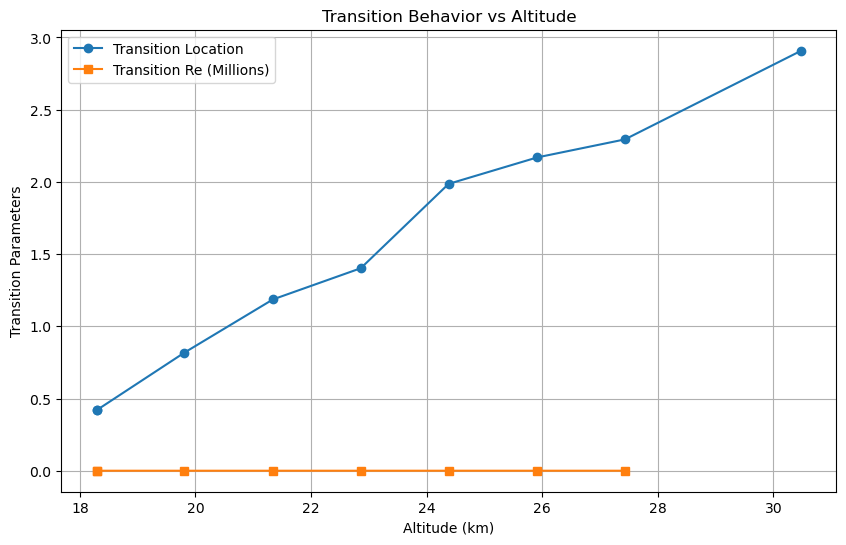

In [2]:
# Analyze transition movement with altitude
plt.figure(figsize=(10, 6))
plt.plot(df_clean['Altitude_km'], df_clean['st(m)'], 'o-', label='Transition Location')
plt.plot(df_clean['Altitude_km'], df_clean['Local Re (Rst)']/1e6, 's-', label='Transition Re (Millions)')
plt.xlabel('Altitude (km)')
plt.ylabel('Transition Parameters')
plt.title('Transition Behavior vs Altitude')
plt.legend()
plt.grid(True)
plt.show()

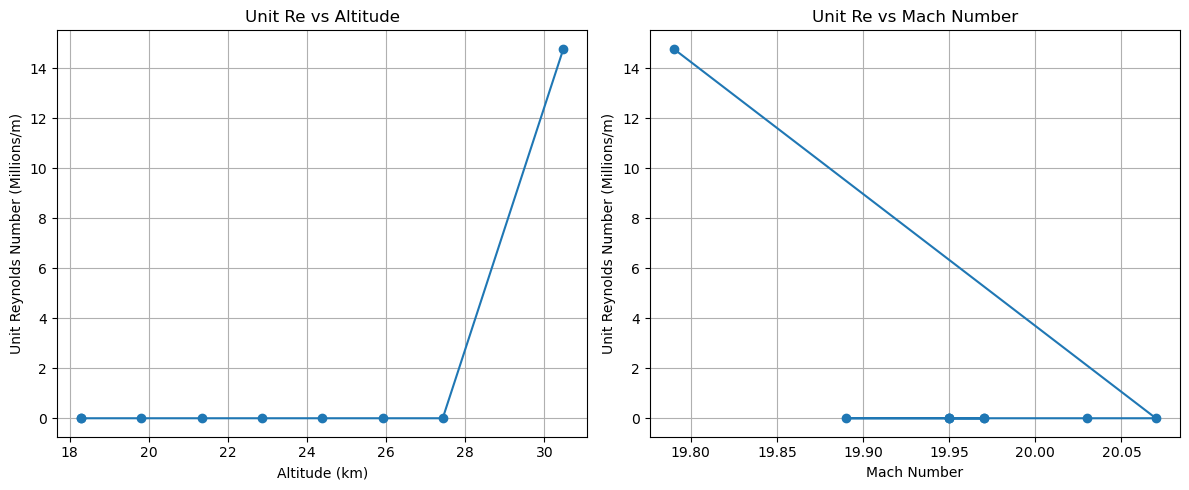

In [3]:
# Analyze unit Reynolds number trends
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df_clean['Altitude_km'], df_clean['Local unit Re (Ri) per m']/1e6, 'o-')
plt.xlabel('Altitude (km)')
plt.ylabel('Unit Reynolds Number (Millions/m)')
plt.title('Unit Re vs Altitude')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_clean['M??'], df_clean['Local unit Re (Ri) per m']/1e6, 'o-')
plt.xlabel('Mach Number')
plt.ylabel('Unit Reynolds Number (Millions/m)')
plt.title('Unit Re vs Mach Number')
plt.grid(True)

plt.tight_layout()
plt.show()

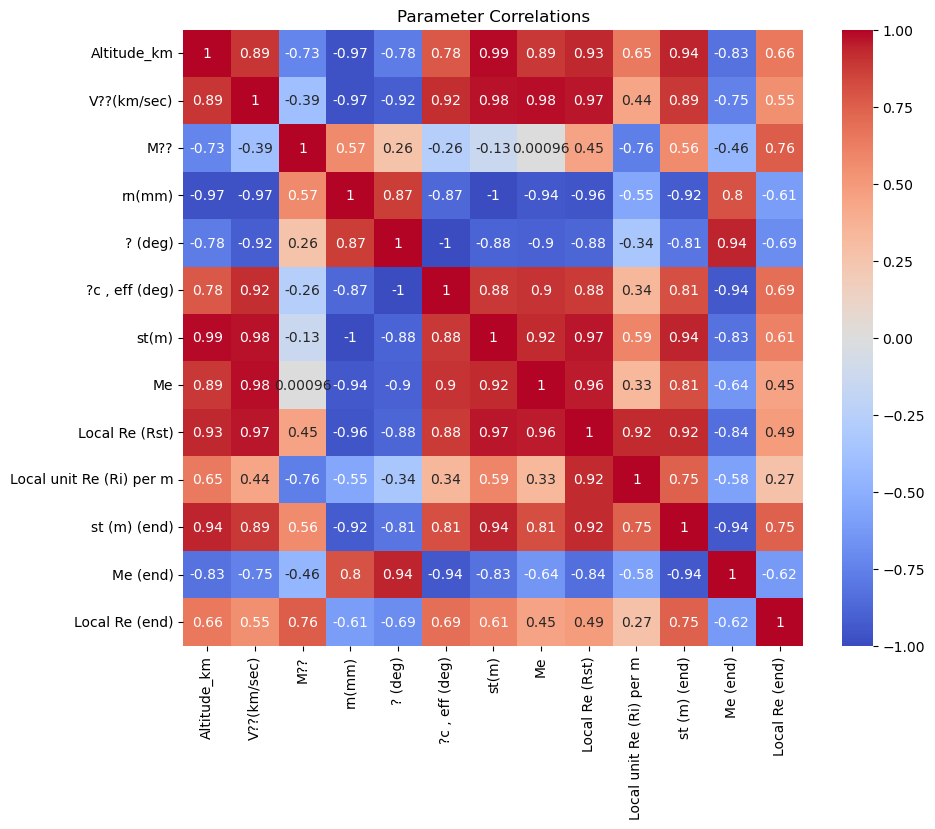

Correlation with Transition Reynolds Number:
Local Re (Rst)              1.000000
st(m)                       0.968435
V??(km/sec)                 0.966143
Me                          0.955045
Altitude_km                 0.931884
st (m) (end)                0.923018
Local unit Re (Ri) per m    0.922870
?c , eff (deg)              0.876183
Local Re (end)              0.485891
M??                         0.447536
Me (end)                   -0.837071
? (deg)                    -0.876183
rn(mm)                     -0.956829
Name: Local Re (Rst), dtype: float64


In [4]:
# Analyze correlations between parameters
import seaborn as sns

correlation_matrix = df_clean.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Parameter Correlations')
plt.show()

# Specifically look at transition correlations
transition_correlations = correlation_matrix['Local Re (Rst)'].sort_values(ascending=False)
print("Correlation with Transition Reynolds Number:")
print(transition_correlations)